In [45]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [4]:
allRatings = []
for l in readCSV("train_Interactions.csv.gz"):
    allRatings.append(l)

In [5]:
ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
bookPerUser = defaultdict(list)
userPerBook = defaultdict(list)
for u,b,r in ratingsTrain:
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))
    bookPerUser[u].append(b)
    userPerBook[b].append(u)



In [9]:
allbooks = set()
for _, book, _ in allRatings:
    allbooks.add(book)
allbooks = list(allbooks)

In [22]:
ratingsValidBinary = [(user, book, 1) for user, book, _ in ratingsValid]
ratingsTrainBinary = [(user, book, 1) for user, book, _ in ratingsTrain]
for user, book, _ in ratingsValid:
    newBook = random.choice(allbooks)
    while newBook in [b for b, _ in ratingsPerUser[user]]:
        newBook = random.choice(allbooks)
    ratingsValidBinary.append((user, newBook, 0))

for user, book, _ in ratingsTrain:
    newBook = random.choice(allbooks)
    while newBook in [b for b, _ in ratingsPerUser[user]]:
        newBook = random.choice(allbooks)
    ratingsTrainBinary.append((user, newBook, 0))

In [56]:


def compute_jaccard(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def compute_cosine(set1, set2):
    intersection = len(set1.intersection(set2))
    return intersection / (len(set1) * len(set2)) if len(set1) * len(set2) != 0 else 0

def create_features(ratingsBinary, ratingsPerItem, ratingsPerUser):
    data = []
    max_popularity = max(len(ratingsPerItem[b]) for b in ratingsPerItem)

    for user, book, label in ratingsBinary:
        users_for_book = set(u for u, _ in ratingsPerItem[book])
        user_books = set(b for b, _ in ratingsPerUser[user] if b != book)
        
        # Calculate max Jaccard similarity
        maxjaccard = 0
        for b in user_books:
            users_for_b = set(u for u, _ in ratingsPerItem[b])
            jac = compute_jaccard(users_for_b, users_for_book)
            if jac > maxjaccard:
                maxjaccard = jac

        maxcosine = 0
        for b in user_books:
            users_for_b = set(u for u, _ in ratingsPerItem[b])
            cos = compute_cosine(users_for_b, users_for_book)
            if cos > maxcosine:
                maxcosine = cos
        
        # Book popularity
        popularity = len(ratingsPerItem[book])
        
        # User's average book popularity
        user_books_count = len(ratingsPerUser[user])
        
        data.append({
            'user': user,
            'book': book,
            'max_jaccard': maxjaccard,
            'max_cosine': maxcosine,
            'book_popularity': popularity,
            'user_books_read': user_books_count,
            'label': label
        })
    
    return pd.DataFrame(data)



In [57]:
# Create feature DataFrames for training and validation
df_train = create_features(ratingsTrainBinary, ratingsPerItem, ratingsPerUser)
df_valid = create_features(ratingsValidBinary, ratingsPerItem, ratingsPerUser)



In [58]:
def train_and_evaluate(train, valid):
    df_train = create_features(train, ratingsPerItem, ratingsPerUser)
    df_valid = create_features(valid, ratingsPerItem, ratingsPerUser)  
    feature_cols = ['book_popularity', 'user_books_read', 'max_jaccard']
    
    X_train = df_train[feature_cols]
    y_train = df_train['label']
    X_valid = df_valid[feature_cols]
    y_valid = df_valid['label']
    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    logreg_param_grid = {
        'C': [0.01, 0.1, 1, 10],  # Inverse of regularization strength
        'penalty': ['l2'],         # Regularization type
        'solver': ['lbfgs']        # Optimization algorithm
    }

    logreg_grid = GridSearchCV(
        LogisticRegression(max_iter=1000, random_state=42),
        logreg_param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    # Train the model
    logreg_grid.fit(X_train_scaled, y_train)

    print(f'Best Logistic Regression Params: {logreg_grid.best_params_}')

    # Best estimator
    best_logreg = logreg_grid.best_estimator_

    # Predictions with the best model
    y_pred_best_logreg = best_logreg.predict(X_valid_scaled)
    y_proba_best_logreg = best_logreg.predict_proba(X_valid_scaled)[:,1]

    # Evaluation
    accuracy_best_logreg = accuracy_score(y_valid, y_pred_best_logreg)
    auc_best_logreg = roc_auc_score(y_valid, y_proba_best_logreg)
    report_best_logreg = classification_report(y_valid, y_pred_best_logreg)

    print(f'Best Logistic Regression Validation Accuracy: {accuracy_best_logreg:.4f}')
    print(f'Best Logistic Regression Validation AUC: {auc_best_logreg:.4f}')
    print('Best Logistic Regression Classification Report:')
    print(report_best_logreg)
    
    matrix = confusion_matrix(y_valid, y_pred_best_logreg)
    _ = ConfusionMatrixDisplay.from_estimator(best_logreg, X_valid_scaled, y_valid)
    importances = best_logreg.coef_[0]
    feature_importances =  pd.Series(importances, index=feature_cols).sort_values(ascending=False)
    print("Feature Importances:")
    print(feature_importances)
    plt.figure(figsize=(8,6))
    feature_importances.plot(kind='bar')
    plt.title('Feature Importances')
    plt.ylabel('Importance Score')
    plt.xlabel('Features')
    plt.show()
    # # Scaling
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_valid_scaled = scaler.transform(X_valid)
    
    # # Initialize Random Forest
    # rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    # gb_clf = GradientBoostingClassifier(random_state=42)
    # xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc')

    # kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # rf_param_grid = {
    #     'n_estimators': [100, 200],
    #     'max_depth': [None, 10, 20],
    #     'min_samples_split': [2, 5],
    #     'min_samples_leaf': [1, 2]
    # }

    # gb_param_grid = {
    #     'n_estimators': [100, 200],
    #     'learning_rate': [0.05, 0.1],
    #     'max_depth': [3, 5],
    #     'subsample': [0.8, 1.0]
    # }

    # xgb_param_grid = {
    #     'n_estimators': [100, 200],
    #     'max_depth': [6, 10],
    #     'learning_rate': [0.05, 0.1],
    #     'subsample': [0.8, 1.0],
    #     'colsample_bytree': [0.8, 1.0]
    # }
    # rf_grid_search = GridSearchCV(
    #     estimator=rf_clf,
    #     param_grid=rf_param_grid,
    #     cv=kfold,
    #     scoring='roc_auc',
    #     n_jobs=-1,
    #     verbose=2
    # )
    # rf_grid_search.fit(X_train_scaled, y_train)
    # best_rf = rf_grid_search.best_estimator_
    # print(f'Best RF Params: {rf_grid_search.best_params_}')

    # # Grid Search for Gradient Boosting
    # gb_grid_search = GridSearchCV(
    #     estimator=gb_clf,
    #     param_grid=gb_param_grid,
    #     cv=kfold,
    #     scoring='roc_auc',
    #     n_jobs=-1,
    #     verbose=2
    # )
    # gb_grid_search.fit(X_train_scaled, y_train)
    # best_gb = gb_grid_search.best_estimator_
    # print(f'Best GB Params: {gb_grid_search.best_params_}')

    # # Grid Search for XGBoost
    # xgb_grid_search = GridSearchCV(
    #     estimator=xgb_clf,
    #     param_grid=xgb_param_grid,
    #     cv=kfold,
    #     scoring='roc_auc',
    #     n_jobs=-1,
    #     verbose=2
    # )
    # xgb_grid_search.fit(X_train_scaled, y_train)
    # best_xgb = xgb_grid_search.best_estimator_
    # print(f'Best XGBoost Params: {xgb_grid_search.best_params_}')
        
    # # Initialize Stacking Classifier
    # stacking_clf = StackingClassifier(
    #     estimators=[
    #         ('rf', best_rf),
    #         ('gb', best_gb),
    #         ('xgb', best_xgb)
    #     ],
    #     final_estimator=LogisticRegression(),
    #     cv=kfold,
    #     n_jobs=-1
    # )

    # # Fit Stacking Classifier
    # stacking_clf.fit(X_train_scaled, y_train)
        
    # y_pred_valid = stacking_clf.predict(X_valid_scaled)
    # y_proba_valid = stacking_clf.predict_proba(X_valid_scaled)[:, 1]

    # accuracy_valid = accuracy_score(y_valid, y_pred_valid)
    # auc_valid = roc_auc_score(y_valid, y_proba_valid)
    # report_valid = classification_report(y_valid, y_pred_valid)

    # print(f'Stacking Ensemble Validation Set Accuracy: {accuracy_valid:.4f}')
    # print(f'Stacking Ensemble Validation Set AUC: {auc_valid:.4f}')
    # print('Validation Set Classification Report:')
    # print(report_valid)

    # importances = best_rf.feature_importances_
    # feature_importances = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
    # print("Feature Importances:")
    # print(feature_importances)
    # plt.figure(figsize=(8,6))
    # feature_importances.plot(kind='bar')
    # plt.title('Feature Importances')
    # plt.ylabel('Importance Score')
    # plt.xlabel('Features')
    # plt.show()


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Logistic Regression Validation Accuracy: 0.6942
Best Logistic Regression Validation AUC: 0.7864
Best Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.90      0.75     10000
           1       0.83      0.49      0.61     10000

    accuracy                           0.69     20000
   macro avg       0.73      0.69      0.68     20000
weighted avg       0.73      0.69      0.68     20000

Feature Importances:
max_jaccard        4.594923
book_popularity    2.487457
user_books_read   -0.652672
dtype: float64


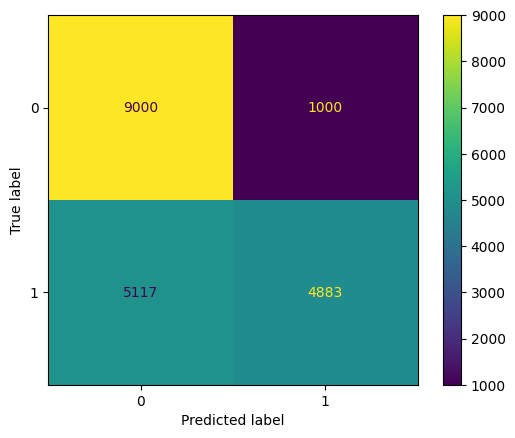

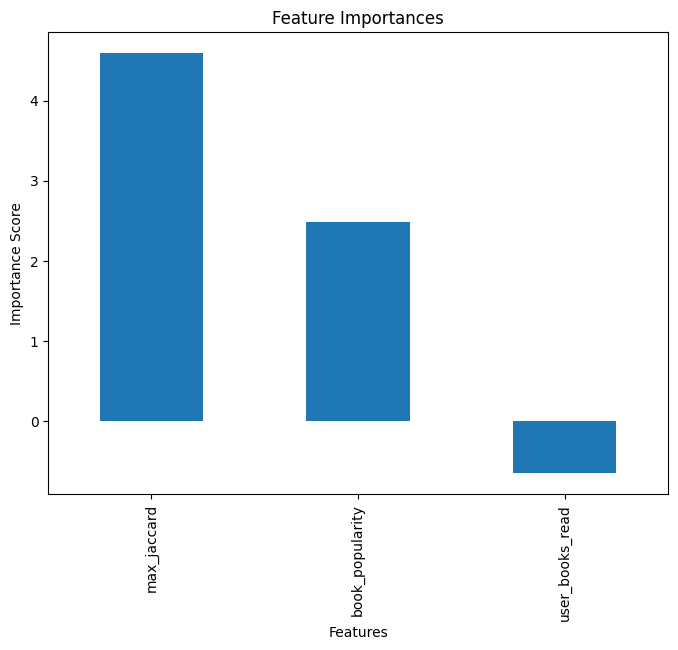

In [ ]:
train_and_evaluate(smallerTrain, ratingsValidBinary)
